In [25]:
# import packages
import pandas as pd
import os
import glob
import random
import numpy as np
import statistics
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.patches as mpatches

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm

## Data Prep

In [26]:
# import word count .csv file from local path
path = r'/Users/spencersu/Desktop/Cincy'
bchmrk = pd.read_csv(os.path.join(path, 'Cincy Benchmark 2019-22.csv')) # 318 rows × 14 columns
wrtlsn = pd.read_csv(os.path.join(path, 'Cincy Writing Lesson 2019-22.csv')) #747 rows × 14 columns

In [27]:
# check if there is na for word count
bchmrk['Word Count'].isnull().any()
wrtlsn['Word Count'].isnull().any()

True

In [28]:
# remove column: the first column "Unnamed: 0"
bchmrk = bchmrk.iloc[:,1:14]

## change data type into integer: 'Word Count' column
# drop nan for Word Count column
bchmrk = bchmrk.dropna(subset=['Word Count'])

# replace ',' with ''
bchmrk['Word Count'].replace(',','',regex=True,inplace=True)

# convert data type of word count column into integer
bchmrk['Word Count'] = bchmrk['Word Count'].astype(int)


# wordcnt dataset now has 315 rows × 13 columns
# data retrieved on Mar 23, 2022

In [29]:
# remove column: the first column "Unnamed: 0"
wrtlsn = wrtlsn.iloc[:,1:14]

## change data type into integer: 'Word Count' column
# drop nan for Word Count column
wrtlsn = wrtlsn.dropna(subset=['Word Count'])

# replace ',' with ''
wrtlsn['Word Count'].replace(',','',regex=True,inplace=True)

# convert data type of word count column into integer
wrtlsn['Word Count'] = wrtlsn['Word Count'].astype(int)

# wordcnt dataset now has 720 rows × 13 columns
# data retrieved on Mar 23, 2022

## Data Overview

In [44]:
## count the unique number of student assignments and students (students has the same number of student assignments for benchmarks)
## also count total writing lessons 

print(bchmrk.groupby(['School Year','Lesson Type','Enrolled Grade'])['Student Assignment ID'].nunique())
print(bchmrk.groupby(['School Year','Lesson Type'])['Student Assignment ID'].nunique())
print(bchmrk.groupby(['School Year'])['Student Assignment ID'].nunique())
print(wrtlsn.groupby(['School Year','Enrolled Grade'])['Student Assignment ID', 'Student ID'].nunique())
print(wrtlsn.groupby(['School Year'])['Student Assignment ID','Student ID'].nunique())


School Year  Lesson Type                   Enrolled Grade
2019-2020    Benchmark - Baseline Writing  7                  1
                                           8                  7
                                           9                 31
                                           10                46
                                           11                15
                                           12                 5
             Benchmark - End-of-Year       8                  1
                                           9                  7
                                           10                 8
                                           11                 5
                                           12                 1
             Benchmark - Mid-Year          7                  1
                                           8                  5
                                           9                 26
                                           10 

In [31]:
# not removing outliers yet
print(wrtlsn.groupby(['School Year','Enrolled Grade'])['Word Count'].mean())#.to_csv(os.path.join(path, 'Word Count Overview.csv'))
print(bchmrk.groupby(['School Year','Lesson Type','Enrolled Grade'])['Word Count'].mean())

School Year  Enrolled Grade
2019-2020    7                 332.000000
             8                 364.958333
             9                 333.208333
             10                223.621212
             11                178.897436
             12                193.000000
2020-2021    9                  87.333333
             10                121.863636
             11                161.050633
             12                248.363636
             13                 56.000000
2021-2022    7                 212.120000
             8                 262.428571
             9                 119.121212
             10                149.770370
             11                104.181818
             12                113.538462
Name: Word Count, dtype: float64
School Year  Lesson Type                   Enrolled Grade
2019-2020    Benchmark - Baseline Writing  7                 118.000000
                                           8                  65.857143
                       

In [32]:
# create two separate datasets for word count and scores respectively (for all school years), and without rubric categories 

# def drop_columns(df_original, groups, y):
#     df = df_original.groupby(groups)[y].mean()
#     df = pd.DataFrame(df)
#     df = df.reset_index()
#     return df

# group1 = ['School Year','School Name','Class Name',
#                 'Lesson Type', 'Class Subject', 'Teacher Name [Sensitive]',
#                 'Student ID', 'Full Name', 'Enrolled Grade', 'Lesson ID', 'Student Assignment ID']

# bchmrk_wc = drop_columns(bchmrk, group1, 'Word Count') # 1779 rows × 12 columns
# wrtlsn_wc = drop_columns(wrtlsn, group1, 'Word Count')

In [34]:
# remove outliers for word count based on year and lesson type

def remove_outlier(df, column, group, y):
    g = df[df[column]==group]
    z = np.abs(stats.zscore(g[y]))
    g['z'] = z
    # threshold = 3
    g = g[g['z']<3]
    g.drop(['z'],axis=1,inplace=True)
    return g

bchmrk2122 = remove_outlier(bchmrk, 'School Year', '2019-2020', 'Word Count') # 213 rows × 13 columns

In [46]:
bchmrk2122.groupby(['Enrolled Grade', 'Lesson Type'])['Word Count'].mean()#.to_csv(os.path.join(path,'Word Count Overview.csv'))

In [49]:
bchmrk2122['new lesson type'] = bchmrk2122['Lesson Type'].map({'Benchmark - Baseline Writing':'Benchmark - Baseline Writing',
                               'Benchmark - Mid-Year':'Benchmark - End-of-Year',
                               'Benchmark - End-of-Year': 'Benchmark - End-of-Year'})

In [52]:
bchmrk2122.groupby(['Enrolled Grade','new lesson type'])['Word Count'].mean()#.to_csv(os.path.join(path,'Word Count Overview2.csv'))

## T-test 

In [39]:
# reshape the dataset so that BOY and MOY can be two columns side by side 

pivotgroup_bchmrk2122 = ['School Name', 'Full Name', 'Enrolled Grade', 'Lesson Type']

bchmrk2122_p = drop_columns(bchmrk2122, pivotgroup_bchmrk2122, 'Word Count')

bchmrk2122_p = bchmrk2122_p.pivot(index=['School Name', 'Full Name','Enrolled Grade'], columns='Lesson Type', values='Word Count')
bchmrk2122_p = bchmrk2122_p.reset_index()

bchmrk2122_p = bchmrk2122_p.dropna()

print(bchmrk2122_p[['Benchmark - Baseline Writing','Benchmark - Mid-Year']].describe())
print(ttest_rel(bchmrk2122_p['Benchmark - Baseline Writing'], bchmrk2122_p['Benchmark - Mid-Year']))

# bchmrk2122_p: 14 rows
## not enough data to suggest a difference

Lesson Type  Benchmark - Baseline Writing  Benchmark - Mid-Year
count                           14.000000             14.000000
mean                            86.321429            125.535714
std                             71.730159             87.659846
min                              8.000000             26.000000
25%                             37.000000             67.750000
50%                             54.500000             99.750000
75%                            153.000000            163.750000
max                            205.000000            301.000000
Ttest_relResult(statistic=-2.3732166618010524, pvalue=0.03373271146551628)


## boxplots

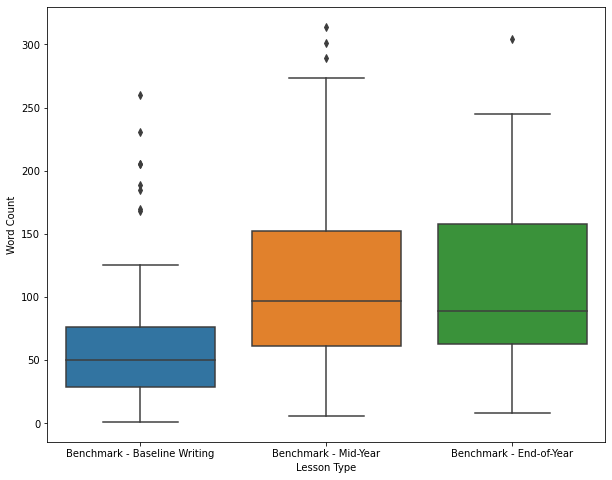

In [43]:
plt.figure(figsize = (10,8))
ax = sns.boxplot(x=bchmrk2122['Lesson Type'],y=bchmrk2122['Word Count'])
# ax.set_title('Grade %d' %n)
# plt.savefig('/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/boxplot grade' + str(n) +'.png')
plt.show()

In [45]:
# bchmrk2122.to_csv(os.path.join(path, 'Cincy Benchmark Scores for Graphs.csv'))

In [54]:
# bchmrk2122.to_csv(os.path.join(path, 'Cincy Benchmark Scores for Graphs2.csv'))

In [55]:
bchmrk2122.groupby('new lesson type')['Word Count'].mean()

new lesson type
Benchmark - Baseline Writing     61.123810
Benchmark - End-of-Year         111.787037
Name: Word Count, dtype: float64